In [2]:
# %load scripts/nbpreamble.py
if not 'RUN_NAME' in locals():
    RUN_NAME = 'unknown'

import sys
import os
import shutil
import glob
import numpy as np
import warnings
import subprocess
import matplotlib
import matplotlib.pyplot as pl
from   matplotlib.patches import Circle, Polygon, RegularPolygon
%matplotlib inline

from desitarget.cuts import select_targets, qso_selection_options

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", module='desitarget')
    # Tries to set mpl backend
    from desitarget.QA import _parse_tcnames

from desiutil.log import get_logger

from importlib import reload

add_sys_path = list()
add_sys_path.append(os.path.join(os.getcwd(),'py'))

WITH_SPHERICAL_GEOMETRY = True
if WITH_SPHERICAL_GEOMETRY:
    add_sys_path.append(os.path.join(os.environ['HOME'],
                                 'software/modules/spherical_geometry/master/lib/python3.6/site-packages/spherical_geometry-1.2.5-py3.6-linux-x86_64.egg/'))

for _ in add_sys_path:
    if _ not in sys.path:
        sys.path.append(_)
                    
from apcsv.astropy_backports import *

if WITH_SPHERICAL_GEOMETRY:
    import spherical_geometry
    from spherical_geometry import polygon as spoly

import astropy
import astropy.units as u
import astropy.coordinates as coord
import regions
from   astropy.io import fits
from   astropy.table import Table, Column

import desiutil
import desiutil.plots
import desimodel
import desimodel.focalplane
import desitarget

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning, module="matplotlib")
    # Tries to set mpl backend
    import desitarget
import desitarget.io as io
import desitarget.mtl

import desitarget.targetmask
from   desitarget.targetmask import desi_mask, bgs_mask, mws_mask, obsmask, obsconditions

import fitsio

# SV planning object classes
import apcsv.plan
reload(apcsv.plan)
from apcsv.plan import Tile, Dither

# Helpful function to deal with multiple warnings
def warning_summary(W):
    if len(W) == 0:
        print('No warnings')
        return
    
    import collections
    d = collections.defaultdict(lambda: 0)
    for _ in W: d[_.category.__name__] += 1
        
    print('{:15s} {:s}'.format('WARNING','COUNT'))
    for k,v in d.items():
        print('{:15s} {:d}'.format(k,v))

# Print some debug info
!date
for m in [astropy,np]:
    print('{:15s} {:20s}'.format(m.__name__,m.version.version))
for m in [desitarget,desimodel]:
    print('{:15s} {:20s}'.format(m.__name__,m._version.__version__))
!echo 'fiberassign    ' $(fiberassign_exec --version)   

print()
print('Path to fiberassign_exec:')
!which fiberassign_exec

print()
print('Working dir:', os.getcwd())

# Write all the files under this path
ROOT_DIR  = os.getcwd()
WORK_ROOT = os.path.join(ROOT_DIR,'runs',RUN_NAME)
print('Files will be written under {}'.format(WORK_ROOT))

if not os.path.exists(WORK_ROOT):
    os.makedirs(WORK_ROOT)
    
print()
print('Files under this directory:')
!tree --noreport -C --filelimit 10 -I '*.py*' $ROOT_DIR

print()
print('Files under the run directory:')
!date
!tree --noreport -C -D --filelimit 10 $WORK_ROOT/run

print()
print('Useful numbers:')
R_TILE = desimodel.focalplane.get_tile_radius_deg()
A_TILE = np.pi*R_TILE**2
print('Tile radius: {:4.3f} deg'.format(R_TILE))
print('Tile area:   {:4.3f} sq.deg.'.format(A_TILE))

# Set up paths
rundir   = os.path.join(WORK_ROOT,'run')
datadir  = os.path.join(rundir,'data')
outdir   = os.path.join(rundir,'output')

for _dir in [rundir,datadir,outdir]:
    os.makedirs(_dir,exist_ok=True)  
    
resource_paths = {
     "skies"  : "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/", 
     "gfas"   : "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/",
}

resource_names = {
    "skies"   : "dr7.1-0.22.0.fits", 
    "gfas"    : "dr7.1.fits",
}

mtl_path           = os.path.join(datadir, 'mtl.fits')
std_path           = os.path.join(datadir, 'std.fits')
local_targets_path = os.path.join(datadir, 'sv_targets.fits')

sky_path     = os.path.join(resource_paths["skies"], 
                          "skies-{}".format(resource_names["skies"]))
gfa_path     = os.path.join(resource_paths["gfas"], 
                          "gfas-{}".format(resource_names["gfas"]))



Sun Jan 13 07:05:38 PST 2019
astropy         2.0.7               
numpy           1.13.3              
desitarget      0.27.0.dev2786      
desimodel       0.9.9.dev464        
fiberassign     0.11.0.dev2265

Path to fiberassign_exec:
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/fiberassign/master/bin/fiberassign_exec

Working dir: /global/u1/a/apcooper/projects/mws_svplan
Files will be written under /global/u1/a/apcooper/projects/mws_svplan/runs/unknown

Files under this directory:
/global/u1/a/apcooper/projects/mws_svplan [13 entries exceeds filelimit, not opening dir]

Files under the run directory:
Sun Jan 13 07:05:39 PST 2019
/global/u1/a/apcooper/projects/mws_svplan/runs/unknown/run
├── [Dec  7 17:12]  data
└── [Dec  7 17:12]  output

Useful numbers:
Tile radius: 1.606 deg
Tile area:   8.101 deg2 sq.deg.


In [4]:
Tile

NameError: name 'Tile' is not defined

In [4]:
R_DITHER = 10.0*u.arcmin
N_DITHER = 12

In [21]:
PCEN_RA  = 270.0
PCEN_DEC = 60.0

In [23]:
C1  = coord.SkyCoord(PCEN_RA,PCEN_DEC,unit='deg',frame='galactic')
wcs = celestial_frame_to_wcs(C1.frame)

# Hack...
wcs.wcs.crval = np.array([PCEN_RA,PCEN_DEC])
wcs.wcs.cdelt = np.array([1/60.0,1/60.0])

wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN'  'GLAT-TAN'  
CRVAL : 270.0  60.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.016666666666666666  0.016666666666666666  
NAXIS : 0  0

In [24]:
D  = Dither(C1.icrs.ra,C1.icrs.dec,N_DITHER,R_DITHER,one_pass_per_dither=False)

In [25]:
print('DESI tile radius = {}'.format(R_TILE))

R       = R_TILE-R_DITHER
print('Complete circle radius = {}'.format(R))

# Hexagons
HSIDE   = R*np.sin(np.pi/6.0)
HAREA   = R*(3.0/2.0)*np.sqrt(3)
print('Complete hexagon area = {:6.3f}'.format(HAREA))

DX         = (R+HSIDE)
DY         = (R*np.sin(np.pi/3.0))

# Sky coordinates
_POINTINGS = [coord.SkyCoord(C1.icrs.ra + _[0], C1.icrs.dec + _[1]) for _ in ((0*u.deg,0*u.deg), 
                                             (DX,DY), 
                                             (DX,-DY))]
# Shift pointings to put vertex at PCEN
POINTINGS_RA  = list()
POINTINGS_DEC = list()
for p in _POINTINGS:
    _d = (0.5*R + HSIDE)
    POINTINGS_RA.append(p.ra-_d)
    POINTINGS_DEC.append(p.dec)
    
POINTINGS = coord.SkyCoord(POINTINGS_RA,POINTINGS_DEC)
print(POINTINGS)

DESI tile radius = 1.6057735024174122 deg
Complete circle radius = 1.4391068357507455 deg
Complete hexagon area =  3.739 deg
<SkyCoord (ICRS): (ra, dec) in deg
    [( 175.64400142,  1.22636509), ( 177.80266167,  2.47266817),
     ( 177.80266167, -0.01993799)]>


In [31]:
class QuickRect():
    def __init__(self,tr,bl):
        self.top_right   = tr
        self.bottom_left = bl
    
    def intersects(self, other):
        c1 = self.top_right.ra    < other.bottom_left.ra
        c2 = self.bottom_left.ra  > other.top_right.ra
        c3 = self.top_right.dec   < other.bottom_left.dec
        c4 = self.bottom_left.dec > other.top_right.dec
        return not (c1 or c2 or c3 or c4)

Total tiles = 36
Complete pattern area = 11.217 deg
173d52m17.6205s 179d34m30.3666s


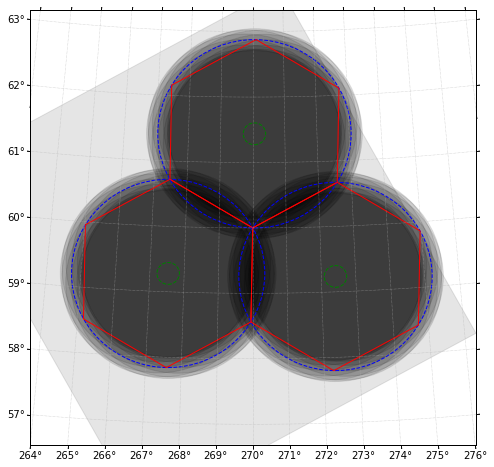

In [38]:
NTILES = len(POINTINGS)*NDITHER
print('Total tiles = {}'.format(NTILES))
print('Complete pattern area = {:6.3f}'.format(len(POINTINGS)*HAREA))

pl.figure(figsize=(8,8))
ax      = pl.subplot(projection=wcs)
patches = list()
kwargs  = dict(fill=True,edgecolor='k',facecolor='k',alpha=0.1,zorder=-10)

np.random.seed(2020)
for cen in POINTINGS:    
    C       = regions.CircleSkyRegion(center=cen,radius=DITHER_RADIUS)
    C_pixel = C.to_pixel(wcs)
    C_pixel.plot(ax=ax,ls='--',edgecolor='g',facecolor='none')

    C       = regions.CircleSkyRegion(center=cen,radius=R)
    C_pixel = C.to_pixel(wcs)
    C_pixel.plot(ax=ax,ls='--',edgecolor='b',facecolor='none')

    # Hexagon in a plane
    H = RegularPolygon((cen.ra.value,cen.dec.value),6,R.value,orientation=np.pi/6.0)
    HvX = H.get_verts()[:,0]    
    HvY = H.get_verts()[:,1]

    H = regions.PolygonSkyRegion(vertices=coord.SkyCoord(HvX, HvY, unit='deg'))
    H_pixel = H.to_pixel(wcs)
    H_pixel.plot(ax=ax,ls='solid',edgecolor='r',facecolor='none')
  
    for i in range(0,NDITHER):
        if DPATTERN == 'random':
            roff = np.sqrt(np.random.random())*DITHER_RADIUS
            toff = (np.random.random()*2-1)*np.pi
            xoff = roff*np.cos(toff)
            yoff = roff*np.sin(toff)
        else:
            xoff = DITHER_RADIUS*np.cos(2*i*np.pi/NDITHER)
            yoff = DITHER_RADIUS*np.sin(2*i*np.pi/NDITHER)

        _cen = coord.SkyCoord(cen.ra + xoff, cen.dec + yoff)

        C       = regions.CircleSkyRegion(center=_cen,radius=R)
        C_pixel = C.to_pixel(wcs)
        C_pixel.plot(ax=ax,**kwargs)

bbox_cen = coord.SkyCoord(C1.icrs.ra-(0.5*R),C1.icrs.dec)

# Define the rectangle around the pattern
dec_t = np.max(POINTINGS.transform_to('icrs').dec) + RADIUS + DITHER_RADIUS
dec_b = np.min(POINTINGS.transform_to('icrs').dec) - RADIUS - DITHER_RADIUS
ra_r  = np.max(POINTINGS.transform_to('icrs').ra) + RADIUS + DITHER_RADIUS
ra_l  = np.min(POINTINGS.transform_to('icrs').ra) - RADIUS - DITHER_RADIUS
print(ra_l,ra_r)

bbox_rect = QuickRect(coord.SkyCoord(ra_r,dec_t,unit=u.deg),
                      coord.SkyCoord(ra_l,dec_b,unit=u.deg))

BBOX     = regions.RectangleSkyRegion(center=bbox_cen,
                                      width=(ra_r-ra_l),
                                      height=(dec_t - dec_b))
BBOX_pixel = BBOX.to_pixel(wcs)
BBOX_pixel.plot(ax=ax,**kwargs)

pl.scatter(bbox_cen.fk5.ra,bbox_cen.fk5.dec,
           s=10,marker='.',zorder=10,transform=ax.get_transform('world'))

#pl.axis('equal')
ax = pl.gca()
ax.coords[0].set_ticks(spacing=1. * u.deg)
ax.coords[0].set_major_formatter('dd')
ax.coords[1].set_ticks(spacing=1. * u.deg)
ax.coords[1].set_major_formatter('dd')
pl.xlim(-200,200-1)
pl.ylim(-200,200-1)
ax.coords.grid(lw=0.5,ls=':')

In [36]:
POINTINGS.icrs.ra

<Longitude [ 175.64400142, 177.80266167, 177.80266167] deg>